In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("Advertising.csv")

In [58]:
df.head()
df.shape

(200, 4)

In [8]:
# We saw earlier that when we're doing linear / polynomial regression, 
# sklearn offers classes that automatically find CV scores for us. 
# Some models won't come with built-in CV scoring, so we want to learn
# how to find CV scores in those cases.


Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

<h3> Train | Test Split Procedure </h3>

In [10]:
# Create X and y 
X = df.drop('sales', axis = 1)
y = df['sales']

# Train | Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h5> Create model </h5>

In [11]:
from sklearn.linear_model import Ridge 

# Choose bad lambda value on purpose
model = Ridge(alpha = 100)
model.fit(X_train_scaled, y_train)

Ridge(alpha=100)

In [13]:
y_test_pred = model.predict(X_test_scaled)

<h5> Evaluation </h5>

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test_pred, y_test)
MAE

1.5535868540768674

Based on this error score, we decide to go back and adjust our lambda parameter. 

In [15]:
# Readjust model's hyper parameter
# Make new prediction
# Compute error

model = Ridge (alpha = 1)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
MAE = mean_absolute_error(y_test_pred, y_test)
MAE


1.2168768443580575

Much better error. 

Let's write a for loop to compute the error for a larger range of lambdas. 


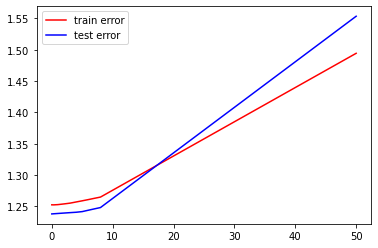

In [62]:
# Find training errors and test errors for different lambda/alpha values

train_errors = []
test_errors = []
lambdas = [0, 0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.03, 0.1, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4,5,6,7, 8, 50]

for i in range (len(lambdas)):
    model = Ridge (alpha = lambdas[i])

    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    MAE_train = mean_absolute_error(y_train_pred, y_train)

    y_test_pred = model.predict(X_test_scaled)
    MAE_test = mean_absolute_error(y_test_pred, y_test)

    train_errors.append(MAE_train)
    test_errors.append(MAE_test)

plt.plot(lambdas, train_errors, color = 'red', label = 'train error')
plt.plot(lambdas, test_errors, color = 'blue', label = 'test error')
plt.legend()

# 'train error' should be lower than 'test error', but this is reversed in the low-alpha region
# 'test error' should be high in the low-alpha region, but it starts off near zero.

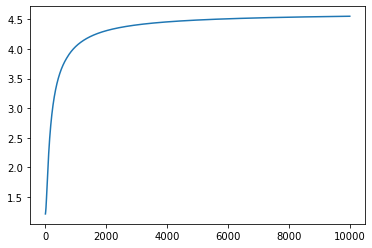

In [40]:
errors = []
lambdas = [0.1*i for i in range(100000)]

for i in range (len(lambdas)):
    model = Ridge (alpha = lambdas[i])
    model.fit(X_train_scaled, y_train)
    y_test_pred = model.predict(X_test_scaled)
    MAE = mean_absolute_error(y_test_pred, y_test)
    errors.append(MAE)

plt.plot(lambdas, errors)

What's confusing me is ... the test error should start off high, and then dip in the middle, and then blow up again. <br>
Obviously if you have no regularisation, you will have high variance, so the model – fitted to the training data – <br>
should not generalise well to the test data, and should initially be high. <br>

I suspect this is because the data set is just randomly / artificially generated.

<h5> Train | Cross Validation | Test </h5>

In [51]:
# Create X and y
X = df.drop('sales',axis=1)
y = df['sales']

In [52]:
# Split the dataset twice to get three separate sets

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)      # X_temp will be divided into CV set and test set.

X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

# Now we have a 70, 15, 15 split between Train, CV, Test. 


In [56]:
# Scale data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

<h5> Create model </h5>

In [66]:
from sklearn.linear_model import Ridge
model = Ridge(alpha = 100)              # Poor choice of lambda on purpose.

model.fit(X_train_scaled, y_train)
y_cv_pred = model.predict(X_cv_scaled)




<h5> Evaluate model </h5>

In [69]:
MSE = mean_squared_error(y_cv_pred, y_cv)
MSE

7.320101458823871

<h5> Now we adjust the lambda parameter and re-evaluate

In [72]:
model = Ridge(alpha = 1)
model.fit(X_train_scaled, y_train)
y_cv_pred = model.predict(X_cv_scaled)

MSE = mean_squared_error(y_cv_pred, y_cv)
MSE

2.3837830750569853

<h5> Now we do final evaluation of our model </h5>

In [73]:
y_test_pred = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_pred, y_test)
MSE

2.2542600838005176

<h3> Cross validation with cross_val_score </h3>

<h5> cross_val_score takes your training set, <br>
and divides it further into a sub-training-set and CV set. <br>
It trains your model on the sub-training-set, and then computes <br>
the error on the CV set. It does this K times (K-fold error computation). <br>
It provides the K error values, from which you can compute the mean.

In [74]:
# Create X and y
X = df.drop('sales',axis=1)
y = df['sales']

# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Note, you only need to divide into training set and test set. 
# cross_val_score will automatically divide the training set into a 
# sub-training-set and CV set, and use the CV set to compute the CV error.

# Scale Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
# Create model

model = Ridge(alpha = 100)

In [76]:
from sklearn.model_selection import cross_val_score

In [78]:
# To see what error computation options there are:

from sklearn.metrics import SCORERS

SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [80]:
# We'll use 'neg_mean_squared_error'

In [87]:
# Compute CV scores using K-folds where K = 5
scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error',cv=5)


In [88]:
scores

array([ -9.32552967,  -4.9449624 , -11.39665242,  -7.0242106 ,
        -8.38562723])

In [89]:
abs(scores).mean()

8.215396464543606

In [96]:
# Adjust lambda parameter and compute CV error again.

model = Ridge (alpha = 1)
scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error',cv=5)
abs(scores).mean()


3.344839296530695

In [98]:
# Now perform final evaluation

model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_pred, y_test)
MSE

2.3190215794287514

<h3> Cross validation with cross_validate </h3>

In [112]:
# Create X and y
X = df.drop('sales',axis=1)
y = df['sales']

# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Note, you only need to divide into training set and test set. 
# cross_val_score will automatically divide the training set into a 
# sub-training-set and CV set, and use the CV set to compute the CV error.

# Scale Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [113]:
model = Ridge (alpha = 100)

In [114]:
from sklearn.model_selection import cross_validate

In [115]:
scores = cross_validate(model,X_train_scaled,y_train, scoring=['neg_mean_absolute_error','neg_mean_squared_error','max_error'],cv=5)

In [116]:
scores

{'fit_time': array([0.00124407, 0.00074387, 0.00074887, 0.00062609, 0.00083804]),
 'score_time': array([0.00078797, 0.00046587, 0.00064516, 0.00047016, 0.00051403]),
 'test_neg_mean_absolute_error': array([-2.31243044, -1.74653361, -2.56211701, -2.01873159, -2.27951906]),
 'test_neg_mean_squared_error': array([ -9.32552967,  -4.9449624 , -11.39665242,  -7.0242106 ,
         -8.38562723]),
 'test_max_error': array([ -6.44988486,  -5.58926073, -10.33914027,  -6.61950405,
         -7.75578515])}

In [117]:
scores=pd.DataFrame(scores)

In [118]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_max_error
0,0.001244,0.000788,-2.312430,-9.325530,-6.449885
1,0.000744,0.000466,-1.746534,-4.944962,-5.589261
2,0.000749,0.000645,-2.562117,-11.396652,-10.339140
3,0.000626,0.000470,-2.018732,-7.024211,-6.619504
4,0.000838,0.000514,-2.279519,-8.385627,-7.755785


In [119]:
scores.mean()

fit_time                        0.000840
score_time                      0.000577
test_neg_mean_absolute_error   -2.183866
test_neg_mean_squared_error    -8.215396
test_max_error                 -7.350715
dtype: float64

In [121]:
# Now adjust and re-evaluate CV error. 

model = Ridge (alpha = 1)

In [122]:
scores = cross_validate(model,X_train_scaled, y_train, scoring=['neg_mean_absolute_error','neg_mean_squared_error','max_error'],cv=5)
scores = pd.DataFrame(scores)
scores.mean()

fit_time                        0.000764
score_time                      0.000548
test_neg_mean_absolute_error   -1.319685
test_neg_mean_squared_error    -3.344839
test_max_error                 -5.161145
dtype: float64

In [123]:
# Now do final evaluation 

model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_pred, y_test)
MSE


2.3190215794287514